In [43]:
import xarray as xr
import os
import pandas as pd
import tqdm
import dask
from dask.delayed import delayed
from dask.diagnostics import ProgressBar
from collections import OrderedDict
from itertools import product
from netCDF4 import Dataset
from cdo import *   # python version
cdo = Cdo()
import matplotlib.pylab as plt
%matplotlib inline
import numpy as np
import matplotlib.pylab as pylab
from matplotlib.ticker import AutoMinorLocator

In [44]:
# parameters cell
input_paths = ['/p/largedata/hhb19/jstreffi/runtime/awicm-3.1/SPIN/outdata/oifs/links/']
input_names = ['SPIN']

climatology_path = ['/p/project/chhb19/streffing1/obs/era5/netcdf/']
climatology_names = ['ERA5']

#exps = range(1, 45)
exps_ctrl = map(lambda x: x + offset, range(9))
figsize=(9,5.56)
dpi = 300
var = 'SKT'

params = {'legend.fontsize': 'large',
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
pylab.rcParams.update(params)

In [45]:
def smooth(x,beta):
    """ kaiser window smoothing """
    window_len=161
    beta=80
    # extending the data at beginning and at the end
    # to apply the window at the borders
    s = np.r_[x[window_len-1:0:-1],x,x[-1:-window_len:-1]]
    w = np.kaiser(window_len,beta)
    y = np.convolve(w/w.sum(),s,mode='valid')
    return y[80:len(y)-80]

In [46]:
# Load ERA5 reanlysis Data

paths=climatology_path[0]+'/'+var+'_mon.nc'
era5 = xr.open_mfdataset(paths, combine="by_coords", engine="netcdf4", use_cftime=True)
era5 = era5.compute()
try:
    era5 = era5.rename({'longitude':'lon','latitude':'lat'})
except:
    pass

era5 = OrderedDict()

In [47]:
# Load model Data

data = OrderedDict()
v=var
paths = []
data[v] = []
for exp in tqdm.tqdm(exps):
    path = input_paths[0]+'/'+v+'_'+f'{exp:05d}.nc'
    data[v].append(cdo.yearmean(input="-fldmean "+str(path),returnArray=v))
    
erapath = climatology_path[0]+'/'+var+'_mon.nc'
era5 = cdo.yearmean(input="-fldmean "+str(path),returnArray=v)

  0%|                                                                                                                                                                                       | 0/44 [00:00<?, ?it/s]

Error in calling operator yearmean with:
>>> cdo -O -f nc -yearmean -fldmean /p/largedata/hhb19/jstreffi/runtime/awicm-3.1/SPIN/outdata/oifs/links//T2M_00001.nc /tmp/cdoPyhj7pxrbc<<<
STDOUT:
STDERR:cdo(1) fldmean: Process started
cdo(1) fldmean: Open failed on >/p/largedata/hhb19/jstreffi/runtime/awicm-3.1/SPIN/outdata/oifs/links//T2M_00001.nc<
                No such file or directory



CDOException: (returncode:1) cdo(1) fldmean: Process started
cdo(1) fldmean: Open failed on >/p/largedata/hhb19/jstreffi/runtime/awicm-3.1/SPIN/outdata/oifs/links//T2M_00001.nc<
                No such file or directory


In [50]:
# extract data
hist = np.squeeze(data['SKT']).flatten()-273.15

KeyError: 'SKT'

ValueError: v cannot be empty

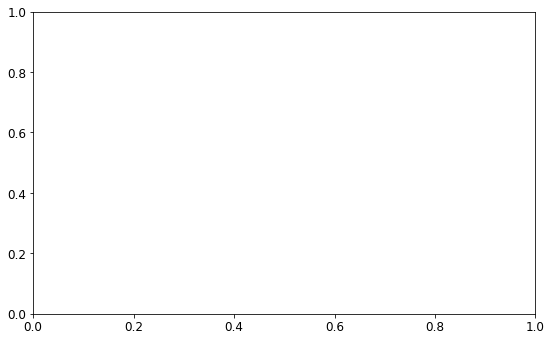

In [51]:
fig, ax = plt.subplots(figsize=figsize)

plt.plot(smooth(hist,len(hist)),color='blue')
plt.plot(hist,linewidth=0.5,color='blue')

plt.ylabel('Surface temperature [C°]',fontsize=13)
plt.xlabel('Spinup year',fontsize=13)

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which='minor', length=4)
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which='minor', length=4)
ax.tick_params(direction='out', length=6, width=2,
               grid_color='r', grid_alpha=0.5)
ax = plt.gca()

plt.savefig('SKT_global_trend_'+input_names[0]+'.png', dpi=dpi)

